## Overview

In this project, we aimed to classify the CIFAR-10 dataset into 10 categories using different architectures. First, we visualized some of our data. Then, we started to classify it by dividing the dataset into training and validation sets.

Six out of the eight models mentioned in the project description were defined using the Keras library. For these models, we followed the same routine. First, we preprocessed our data using each model's specific preprocessor. Then, we introduced a model that upsampled the data (with different dimensions for each architecture). After upsampling, we used the model with its pretrained weights and added extra layers, each with a sigmoid activation function. These newly added layers varied for each model, and all the models ended with a softmax layer. We trained each architecture using two optimizers: Adam and SGD. Overall, the Adam optimizer performed better.

As the two other models were not defined in a library, we implemented them manually. Each architecture was evaluated based on its results on the test data. The evaluation metrics included accuracy, precision, recall, F1 score, and a confusion matrix.

## Imports

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

In [15]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Loading Data
We will load the dataset from Keras.

In [16]:
(training_images, training_labels) , (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

### Visualize Dataset

View some of the trainset and some of the testset


### Trainset Visualization


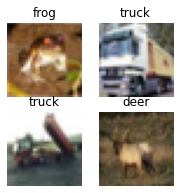

In [15]:
plt.figure(figsize=(3,3))

for i in range(4):
    plt.subplot(22*10 + i + 1)
    plt.axis('off')
    plt.title(classes[int(training_labels[i])])
    plt.imshow(training_images[i])
    
plt.show()

### Testset Visualization

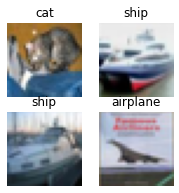

In [16]:
plt.figure(figsize=(3,3))

for i in range(4):
    plt.subplot(22*10 + i + 1)
    plt.axis('off')
    plt.title(classes[int(test_labels[i])])
    plt.imshow(test_images[i])
    
plt.show()

#### ResNet

### Preprocess Dataset
Here, we'll perform normalization on images in training and validation set. 
- We'll use the function preprocess_input from the ResNet50 model in Keras.
- We'll do the same thing for each of the models

In [17]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [18]:
# Preprocess both the trainset and the testset
train_X = preprocess_image_input(training_images)
test_X = preprocess_image_input(test_images)

### Split trainset to trainset and validation set


In [17]:
# Split the trainset with 0.2 ratio
train_X, val_X, training_labels, val_labels = train_test_split(
    training_images, training_labels, test_size=0.2, random_state=1
)

## Define the Network
We will be performing transfer learning on **ResNet50** available in Keras.
- We'll load pre-trained **imagenet weights** to the model.
- We'll choose to retain all layers of **ResNet50** along with the final classification layers.

We'll take the same steps for each of the models

In [20]:
def feature_extractor(inputs):
#     use pretained version of resnet with imagenet's weigths.
#     Also as we upsampled our data the inout shape is 224*224*3 
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor



def classifier(inputs):
# for our untrained layers, first we perform average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
#     Then we add 3 dense layers with sizes 1024, 512, 10
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x


def final_model(inputs):
#     We upsample each of our images
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    
#     Get the output of the Restnet
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output


def define_compile_model(optimize):
#     first we define our input layer
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
#     Then we define our model with inputs from the Resnet and outputs from the additional layers
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer=optimize, 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model_adam = define_compile_model('adam')

model_adam.summary()

94773248/94765736 [==============================] - 5s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_______________________________________________________

## Train the model with adam optimizer

In [21]:
# Train our model using validation set
EPOCHS = 3
history = model_adam.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=64)

Epoch 1/3
625/625 [==============================] - 205s 328ms/step - loss: 0.8504 - accuracy: 0.7092 - val_loss: 1.0084 - val_accuracy: 0.6738
Epoch 2/3
625/625 [==============================] - 204s 327ms/step - loss: 0.4676 - accuracy: 0.8414 - val_loss: 0.7155 - val_accuracy: 0.7721
Epoch 3/3
625/625 [==============================] - 204s 327ms/step - loss: 0.3406 - accuracy: 0.8842 - val_loss: 0.5177 - val_accuracy: 0.8333


## Evaluate the Model with adam optimizer

Calculate accuracy, precision, recall, f1 score metrics

In [43]:
# Evaluate our model based on its prediction on test set
model_adam_pred = np.argmax(model_adam.predict(test_X, batch_size=64), axis=-1)

In [51]:
# Calculate the metrics
accuracy = accuracy_score(test_labels, model_adam_pred)
precision = precision_score(test_labels, model_adam_pred, average='weighted')
recall = recall_score(test_labels, model_adam_pred, average='weighted')
f1 = f1_score(test_labels, model_adam_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8291
Precision: 0.8388579049813774
Recall: 0.8291
F1 Score: 0.8286191948063035


## Train the model with SGD optimizer

In [23]:
model_SGD = define_compile_model('SGD')
model_SGD.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

In [24]:
EPOCHS = 3
history = model_SGD.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=64)

Epoch 1/3
625/625 [==============================] - 204s 326ms/step - loss: 0.4464 - accuracy: 0.8537 - val_loss: 0.2298 - val_accuracy: 0.9197
Epoch 2/3
625/625 [==============================] - 203s 324ms/step - loss: 0.1128 - accuracy: 0.9647 - val_loss: 0.1704 - val_accuracy: 0.9420
Epoch 3/3
625/625 [==============================] - 203s 324ms/step - loss: 0.0392 - accuracy: 0.9885 - val_loss: 0.1655 - val_accuracy: 0.9486


## Evaluate the Model with SGD optimizer

Calculate accuracy, precision, recall, f1 score metrics

In [52]:
model_SGD_pred = np.argmax(model_SGD.predict(test_X, batch_size=64), axis=-1)

In [53]:
accuracy = accuracy_score(test_labels, model_SGD_pred)
precision = precision_score(test_labels, model_SGD_pred, average='weighted')
recall = recall_score(test_labels, model_SGD_pred, average='weighted')
f1 = f1_score(test_labels, model_SGD_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9452
Precision: 0.94554871151864
Recall: 0.9452
F1 Score: 0.9452601824877344


## Follow the exact same steps for VGG16

In [13]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.vgg16.preprocess_input(input_images)
  return output_ims

In [16]:
train_X = preprocess_image_input(training_images)
test_X = preprocess_image_input(test_images)
train_X, val_X, training_labels, val_labels = train_test_split(
    train_X, training_labels, test_size=0.2, random_state=1
)

In [24]:
def feature_extractor(inputs):
#     No upsampling so the shape is still 32*32*3
  feature_extractor = tf.keras.applications.VGG16(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor



def classifier(inputs):
#     as our input shape is smaller we prefered smaller layers
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x


def final_model(inputs):

    vgg_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(vgg_feature_extractor)

    return classification_output


def define_compile_model(optimize):
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer=optimize, 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


In [25]:
model_adam = define_compile_model('adam')
model_adam.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
classification (Dense)       (None, 10)               

In [26]:
EPOCHS = 10
history = model_adam.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=64)

Epoch 1/10
625/625 [==============================] - 15s 24ms/step - loss: 2.0432 - accuracy: 0.2277 - val_loss: 1.6814 - val_accuracy: 0.3195
Epoch 2/10
625/625 [==============================] - 14s 23ms/step - loss: 1.4977 - accuracy: 0.4151 - val_loss: 1.2307 - val_accuracy: 0.5458
Epoch 3/10
625/625 [==============================] - 14s 23ms/step - loss: 1.1249 - accuracy: 0.5933 - val_loss: 1.0344 - val_accuracy: 0.6531
Epoch 4/10
625/625 [==============================] - 14s 23ms/step - loss: 0.8972 - accuracy: 0.6905 - val_loss: 0.8705 - val_accuracy: 0.7069
Epoch 5/10
625/625 [==============================] - 14s 23ms/step - loss: 0.7624 - accuracy: 0.7427 - val_loss: 0.8201 - val_accuracy: 0.7299
Epoch 6/10
625/625 [==============================] - 14s 23ms/step - loss: 0.6772 - accuracy: 0.7734 - val_loss: 0.7476 - val_accuracy: 0.7553
Epoch 7/10
625/625 [==============================] - 14s 23ms/step - loss: 0.6112 - accuracy: 0.7991 - val_loss: 0.7837 - val_accuracy:

In [37]:
model_adam_pred = np.argmax(model_adam.predict(test_X, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_adam_pred)
precision = precision_score(test_labels, model_adam_pred, average='weighted')
recall = recall_score(test_labels, model_adam_pred, average='weighted')
f1 = f1_score(test_labels, model_adam_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_adam_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.7775
Precision: 0.7769355709232549
Recall: 0.7775
F1 Score: 0.7756905174036605
Confusion matrix:[[802   9  32  33  13   3   4  13  64  27]
 [ 10 885   0   8   0   2   7   1  22  65]
 [ 71   0 604  54  94  60  89  13  13   2]
 [ 14   4  56 556  48 192  64  40  18   8]
 [ 15   0  44  42 771  26  51  44   2   5]
 [  5   1  33  96  35 758  19  51   1   1]
 [  5   2  15  53  27  17 876   2   3   0]
 [ 15   1  19  29  62  53   1 814   1   5]
 [ 69  29   4   7   2   3   7   4 861  14]
 [ 23  63   3  14   3   3   7  25  11 848]]


In [30]:
model_SGD = define_compile_model('SGD')
model_SGD.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
classification (Dense)       (None, 10)               

In [32]:
EPOCHS = 10
history = model_SGD.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=64)

Epoch 1/10
625/625 [==============================] - 14s 22ms/step - loss: 1.4847 - accuracy: 0.4606 - val_loss: 0.7812 - val_accuracy: 0.7417
Epoch 2/10
625/625 [==============================] - 14s 22ms/step - loss: 0.7125 - accuracy: 0.7614 - val_loss: 0.7204 - val_accuracy: 0.7630
Epoch 3/10
625/625 [==============================] - 14s 22ms/step - loss: 0.4935 - accuracy: 0.8316 - val_loss: 0.5236 - val_accuracy: 0.8230
Epoch 4/10
625/625 [==============================] - 14s 22ms/step - loss: 0.3644 - accuracy: 0.8752 - val_loss: 0.5278 - val_accuracy: 0.8293
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 0.2700 - accuracy: 0.9067 - val_loss: 0.4849 - val_accuracy: 0.8453
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 0.2030 - accuracy: 0.9301 - val_loss: 0.5338 - val_accuracy: 0.8404
Epoch 7/10
625/625 [==============================] - 14s 22ms/step - loss: 0.1452 - accuracy: 0.9495 - val_loss: 0.6659 - val_accuracy:

In [38]:
model_SGD_pred = np.argmax(model_SGD.predict(test_X, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_SGD_pred)
precision = precision_score(test_labels, model_SGD_pred, average='weighted')
recall = recall_score(test_labels, model_SGD_pred, average='weighted')
f1 = f1_score(test_labels, model_SGD_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_SGD_pred)

                                 
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.8449
Precision: 0.8468079424560964
Recall: 0.8449
F1 Score: 0.8450005758321071
Confusion matrix:[[898   3  26   9  14   0   2   8  27  13]
 [ 10 917   3   5   0   3   8   3  11  40]
 [ 40   0 835  24  34  20  31  10   5   1]
 [ 12   3  44 719  38  96  60  15   6   7]
 [ 12   1  40  32 835  24  46   7   3   0]
 [  5   0  40 174  29 708  24  16   2   2]
 [  4   2  23  30  12  10 917   1   1   0]
 [ 10   0  20  33  45  59   7 823   1   2]
 [ 39   7   5   5   3   1   4   1 926   9]
 [ 22  55   3  17   2   1   7   4  18 871]]


## Follow the exact same steps for EfficientNet

In [20]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.efficientnet.preprocess_input(input_images)
  return output_ims

In [ ]:
train_X = preprocess_image_input(training_images)
test_X = preprocess_image_input(test_images)
train_X, val_X, training_labels, val_labels = train_test_split(
    train_X, training_labels, test_size=0.2, random_state=1
)

In [22]:
def feature_extractor(inputs):
#  we upsampled the input by 5, so the EfficientNet's inout is now 160*160*3
  feature_extractor = tf.keras.applications.EfficientNetB0(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor



def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(5,5))(inputs)
    efficient_feature_extractor = feature_extractor(resize)
    classification_output = classifier(efficient_feature_extractor)

    return classification_output


def define_compile_model(optimize):
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer=optimize, 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


In [23]:
model_adam = define_compile_model('adam')
model_adam.summary()

16711680/16705208 [==============================] - 1s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 160, 160, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 5, 5, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               327936    
_______________________________________________________

In [ ]:
EPOCHS = 5
history = model_adam.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=64)

In [49]:
model_adam_pred = np.argmax(model_adam.predict(test_X, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_adam_pred)
precision = precision_score(test_labels, model_adam_pred, average='weighted')
recall = recall_score(test_labels, model_adam_pred, average='weighted')
f1 = f1_score(test_labels, model_adam_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_adam_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.9012
Precision: 0.9080652659942796
Recall: 0.9012
F1 Score: 0.9025099160899756
Confusion matrix:[[866   4  31  13   8  15   3   7  45   8]
 [  2 945   1   1   2  12   1   5  11  20]
 [ 12   1 888  32  17  39   7   2   2   0]
 [  3   1  12 844  20 107   5   4   3   1]
 [  1   0  16  14 932  24   3   9   1   0]
 [  0   0   4  53  13 929   0   0   1   0]
 [  2   0  25  37  20  39 875   0   2   0]
 [  3   0   2  12  29  98   0 855   1   0]
 [ 11   1   4   2   1   3   2   3 967   6]
 [  7  40   3   3   2   8   4  10  12 911]]


In [50]:
model_SGD = define_compile_model('SGD')
model_SGD.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 160, 160, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 5, 5, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               327936    
_________________________________________________________________
dense_15 (Dense)             (None, 128)             

In [52]:
EPOCHS = 5
history = model_SGD.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=64)

Epoch 1/5
625/625 [==============================] - 136s 217ms/step - loss: 1.3087 - accuracy: 0.6034 - val_loss: 0.5239 - val_accuracy: 0.8340
Epoch 2/5
625/625 [==============================] - 134s 214ms/step - loss: 0.4131 - accuracy: 0.8647 - val_loss: 0.2911 - val_accuracy: 0.9052
Epoch 3/5
625/625 [==============================] - 136s 218ms/step - loss: 0.2837 - accuracy: 0.9032 - val_loss: 0.2220 - val_accuracy: 0.9272
Epoch 4/5
625/625 [==============================] - 134s 214ms/step - loss: 0.2228 - accuracy: 0.9251 - val_loss: 0.1917 - val_accuracy: 0.9364
Epoch 5/5
625/625 [==============================] - 134s 214ms/step - loss: 0.1803 - accuracy: 0.9372 - val_loss: 0.1767 - val_accuracy: 0.9413


In [53]:
model_SGD_pred = np.argmax(model_SGD.predict(test_X, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_SGD_pred)
precision = precision_score(test_labels, model_SGD_pred, average='weighted')
recall = recall_score(test_labels, model_SGD_pred, average='weighted')
f1 = f1_score(test_labels, model_SGD_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_SGD_pred)

                                 
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.9382
Precision: 0.938342867706956
Recall: 0.9382
F1 Score: 0.938167086494777
Confusion matrix:[[952   4  13   2   3   0   0   3  17   6]
 [  5 962   0   0   0   1   3   0   3  26]
 [ 15   0 919  18  17   9  11   7   3   1]
 [  6   0  14 855  13  89  15   4   2   2]
 [  2   0   6  14 942   8   9  18   1   0]
 [  0   0   7  54   8 918   2  10   1   0]
 [  4   1   9  16   5   2 959   2   2   0]
 [  4   0   6   4  16  19   0 951   0   0]
 [ 24   9   1   0   1   1   1   0 958   5]
 [  6  20   0   0   1   0   0   1   6 966]]


## Follow the exact same steps for MobileNet

In [5]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.mobilenet.preprocess_input(input_images)
  return output_ims

In [6]:
train_X = preprocess_image_input(training_images)
test_X = preprocess_image_input(test_images)
train_X, val_X, training_labels, val_labels = train_test_split(
    train_X, training_labels, test_size=0.2, random_state=1
)

In [7]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor



def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x


def final_model(inputs):
    mobile_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(mobile_feature_extractor)

    return classification_output


def define_compile_model(optimize):
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer=optimize, 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


In [8]:
model_adam = define_compile_model('adam')
model_adam.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________

In [11]:
EPOCHS = 10
history = model_adam.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size= 128)

Epoch 1/10
313/313 [==============================] - 7s 21ms/step - loss: 0.7604 - accuracy: 0.7615 - val_loss: 3.1603 - val_accuracy: 0.4289
Epoch 2/10
313/313 [==============================] - 7s 21ms/step - loss: 0.6872 - accuracy: 0.7823 - val_loss: 5.9482 - val_accuracy: 0.2309
Epoch 3/10
313/313 [==============================] - 7s 21ms/step - loss: 0.6250 - accuracy: 0.7977 - val_loss: 13.3632 - val_accuracy: 0.1316
Epoch 4/10
313/313 [==============================] - 7s 21ms/step - loss: 0.4843 - accuracy: 0.8429 - val_loss: 4.0792 - val_accuracy: 0.5542
Epoch 5/10
313/313 [==============================] - 7s 21ms/step - loss: 0.4133 - accuracy: 0.8663 - val_loss: 2.3264 - val_accuracy: 0.5942
Epoch 6/10
313/313 [==============================] - 7s 21ms/step - loss: 0.3765 - accuracy: 0.8789 - val_loss: 1.4097 - val_accuracy: 0.6667
Epoch 7/10
313/313 [==============================] - 7s 21ms/step - loss: 0.3799 - accuracy: 0.8755 - val_loss: 2.2262 - val_accuracy: 0.625

In [12]:
model_adam_pred = np.argmax(model_adam.predict(test_X, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_adam_pred)
precision = precision_score(test_labels, model_adam_pred, average='weighted')
recall = recall_score(test_labels, model_adam_pred, average='weighted')
f1 = f1_score(test_labels, model_adam_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_adam_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.6234
Precision: 0.7163965957088658
Recall: 0.6234
F1 Score: 0.6259818593770229
Confusion matrix:[[583   4  27  26  16  21   1 121  79 122]
 [  7 652   1   7   0  14   0 104   0 215]
 [ 38   4 520  63  33 102   2 215   8  15]
 [  4   1  31 385  21 279   1 224   3  51]
 [  4   2  42  44 357  58   1 478   8   6]
 [  2   1  13  57   1 669   0 241   3  13]
 [  3   4  35  94  37 167 464 112   7  77]
 [  0   0   5   4   2  22   0 962   0   5]
 [ 27  42   4  18   2   9   0  30 711 157]
 [  5   5   1   4   2   4   1  43   4 931]]


In [13]:
model_SGD = define_compile_model('SGD')
model_SGD.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
classification (Dense)       (None, 10)               

In [15]:
EPOCHS = 10
history = model_SGD.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=128)

Epoch 1/10
313/313 [==============================] - 8s 25ms/step - loss: 1.5944 - accuracy: 0.4324 - val_loss: 2.2510 - val_accuracy: 0.1328
Epoch 2/10
313/313 [==============================] - 7s 21ms/step - loss: 1.3350 - accuracy: 0.5311 - val_loss: 2.2511 - val_accuracy: 0.1338
Epoch 3/10
313/313 [==============================] - 7s 21ms/step - loss: 1.1680 - accuracy: 0.5970 - val_loss: 2.1691 - val_accuracy: 0.1807
Epoch 4/10
313/313 [==============================] - 7s 21ms/step - loss: 1.0407 - accuracy: 0.6430 - val_loss: 2.1691 - val_accuracy: 0.2181
Epoch 5/10
313/313 [==============================] - 7s 21ms/step - loss: 0.9520 - accuracy: 0.6743 - val_loss: 2.1423 - val_accuracy: 0.2602
Epoch 6/10
313/313 [==============================] - 7s 21ms/step - loss: 0.8779 - accuracy: 0.7016 - val_loss: 2.0757 - val_accuracy: 0.3179
Epoch 7/10
313/313 [==============================] - 7s 21ms/step - loss: 0.8171 - accuracy: 0.7219 - val_loss: 1.9671 - val_accuracy: 0.4163

In [16]:
model_SGD_pred = np.argmax(model_SGD.predict(test_X, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_SGD_pred)
precision = precision_score(test_labels, model_SGD_pred, average='weighted')
recall = recall_score(test_labels, model_SGD_pred, average='weighted')
f1 = f1_score(test_labels, model_SGD_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_SGD_pred)

                                 
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.5987
Precision: 0.7186975357610162
Recall: 0.5987
F1 Score: 0.6223179890462558
Confusion matrix:[[615   3  39 191  69   1   4   4  52  22]
 [ 57 662   1 115  15   3  20   2  63  62]
 [ 46   1 262 463 119  44  55   5   3   2]
 [  4   0  15 720  44 167  37   4   5   4]
 [  5   1  12 292 625  17  35  12   1   0]
 [  1   0   4 412  34 535   5   8   1   0]
 [  1   3  17 225  49  21 683   0   1   0]
 [  3   0   5 369 138  45   2 436   0   2]
 [ 54  12  10  94  42   0   2   1 778   7]
 [ 21  48   1 155   8   1   3   6  86 671]]


## Follow the exact same steps for DenseNet

In [26]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.densenet.preprocess_input(input_images)
  return output_ims

In [27]:
train_X = preprocess_image_input(training_images)
test_X = preprocess_image_input(test_images)
train_X, val_X, training_labels, val_labels = train_test_split(
    train_X, training_labels, test_size=0.2, random_state=1
)

In [31]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.DenseNet121(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor



def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(3,3))(inputs)
    mobile_feature_extractor = feature_extractor(resize)
    classification_output = classifier(mobile_feature_extractor)

    return classification_output


def define_compile_model(optimize):
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer=optimize, 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


In [32]:
model_adam = define_compile_model('adam')
model_adam.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 96, 96, 3)         0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_14 (Dense)             (None, 128)             

In [33]:
EPOCHS = 5
history = model_adam.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size= 64)

Epoch 1/5
625/625 [==============================] - 61s 97ms/step - loss: 0.6492 - accuracy: 0.7837 - val_loss: 0.9438 - val_accuracy: 0.7079
Epoch 2/5
625/625 [==============================] - 59s 94ms/step - loss: 0.3860 - accuracy: 0.8704 - val_loss: 0.4787 - val_accuracy: 0.8455
Epoch 3/5
625/625 [==============================] - 59s 94ms/step - loss: 0.3045 - accuracy: 0.8969 - val_loss: 0.7162 - val_accuracy: 0.7862
Epoch 4/5
625/625 [==============================] - 59s 94ms/step - loss: 0.2487 - accuracy: 0.9157 - val_loss: 0.6916 - val_accuracy: 0.7996
Epoch 5/5
625/625 [==============================] - 59s 94ms/step - loss: 0.2083 - accuracy: 0.9290 - val_loss: 0.4318 - val_accuracy: 0.8696


In [34]:
model_adam_pred = np.argmax(model_adam.predict(test_X, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_adam_pred)
precision = precision_score(test_labels, model_adam_pred, average='weighted')
recall = recall_score(test_labels, model_adam_pred, average='weighted')
f1 = f1_score(test_labels, model_adam_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_adam_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.8686
Precision: 0.8805934888139988
Recall: 0.8686
F1 Score: 0.8684301143622338
Confusion matrix:[[891   3  28   2   4   3   3   0  42  24]
 [  9 830   1   0   2   5   0   0   7 146]
 [ 12   0 862   6  44  35  30   0   7   4]
 [  8   1  30 689  62 155  30   4  11  10]
 [  2   0  19   8 939  13  10   1   7   1]
 [  2   0   9  25  52 899   8   2   2   1]
 [ 10   1   9  12  31  15 918   0   2   2]
 [ 20   0  25   6 137  48   2 755   2   5]
 [ 21   4   4   3   1   4   1   0 947  15]
 [  8   6   0   3   2   4   1   0  20 956]]


In [35]:
model_SGD = define_compile_model('SGD')
model_SGD.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 96, 96, 3)         0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1024)              0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_16 (Dense)             (None, 128)             

In [36]:
EPOCHS = 5
history = model_SGD.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=64)

Epoch 1/5
625/625 [==============================] - 59s 94ms/step - loss: 0.4947 - accuracy: 0.8375 - val_loss: 0.2411 - val_accuracy: 0.9179
Epoch 2/5
625/625 [==============================] - 57s 91ms/step - loss: 0.1589 - accuracy: 0.9474 - val_loss: 0.2062 - val_accuracy: 0.9290
Epoch 3/5
625/625 [==============================] - 57s 91ms/step - loss: 0.0731 - accuracy: 0.9767 - val_loss: 0.1874 - val_accuracy: 0.9398
Epoch 4/5
625/625 [==============================] - 57s 91ms/step - loss: 0.0362 - accuracy: 0.9889 - val_loss: 0.1941 - val_accuracy: 0.9397
Epoch 5/5
625/625 [==============================] - 57s 91ms/step - loss: 0.0210 - accuracy: 0.9942 - val_loss: 0.2045 - val_accuracy: 0.9418


In [37]:
model_SGD_pred = np.argmax(model_SGD.predict(test_X, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_SGD_pred)
precision = precision_score(test_labels, model_SGD_pred, average='weighted')
recall = recall_score(test_labels, model_SGD_pred, average='weighted')
f1 = f1_score(test_labels, model_SGD_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_SGD_pred)

                                 
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.9418
Precision: 0.9419485238303245
Recall: 0.9418
F1 Score: 0.9418601995294037
Confusion matrix:[[957   2  14   4   1   0   2   3  13   4]
 [  4 966   0   0   0   0   0   1   5  24]
 [  7   0 944  14   9  10   8   6   2   0]
 [  2   1  13 879   9  70  12  11   2   1]
 [  1   0  16  19 935   9   4  14   2   0]
 [  2   0   9  67  11 895   1  14   1   0]
 [  1   0  10  15   4   5 964   1   0   0]
 [  5   0   5   8  14  16   0 952   0   0]
 [ 15   4   0   1   1   1   2   0 969   7]
 [  8  27   0   2   0   0   0   0   6 957]]


## Follow the exact same steps for CovNet

In [4]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.convnext.preprocess_input(input_images)
  return output_ims

In [5]:
train_X = preprocess_image_input(training_images)
test_X = preprocess_image_input(test_images)
train_X, val_X, training_labels, val_labels = train_test_split(
    train_X, training_labels, test_size=0.2, random_state=1
)

In [6]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.ConvNeXtTiny(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor



def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(5,5))(inputs)
    mobile_feature_extractor = feature_extractor(resize)
    classification_output = classifier(mobile_feature_extractor)

    return classification_output


def define_compile_model(optimize):
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer=optimize, 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


In [7]:
model_adam = define_compile_model('adam')
model_adam.summary()

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 5, 5, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,347,754 (108.14 MB)

 Trainable params: 28,347,754 (108.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 5
history = model_adam.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size= 64)

In [10]:
model_adam_pred = np.argmax(model_adam.predict(test_X, batch_size=64), axis=-1)


157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step


In [11]:
accuracy = accuracy_score(test_labels, model_adam_pred)
precision = precision_score(test_labels, model_adam_pred, average='weighted')
recall = recall_score(test_labels, model_adam_pred, average='weighted')
f1 = f1_score(test_labels, model_adam_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_adam_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.9196
Precision: 0.9229450727656707
Recall: 0.9196
F1 Score: 0.9196277712488391
Confusion matrix:[[885   6  24   9  24   0   3  12  21  16]
 [  1 932   0   0   0   0   0   3   5  59]
 [  4   0 897   9  51  12   7  17   2   1]
 [  2   1  14 843  56  43   7  25   3   6]
 [  0   0   3   4 979   4   3   7   0   0]
 [  1   1   6  61  31 842   3  47   0   8]
 [  1   1  22  17  35   5 909   4   3   3]
 [  1   0   1   6  24   2   0 965   0   1]
 [  7   7   2   1   0   0   1   1 977   4]
 [  3  17   2   3   1   0   0   2   5 967]]


In [12]:
model_SGD = define_compile_model('SGD')
model_SGD.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 5, 5, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,347,754 (108.14 MB)

 Trainable params: 28,347,754 (108.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 5
history = model_SGD.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=64)

In [ ]:
model_SGD_pred = np.argmax(model_SGD.predict(test_X, batch_size=64), axis=-1)

In [15]:
accuracy = accuracy_score(test_labels, model_SGD_pred)
precision = precision_score(test_labels, model_SGD_pred, average='weighted')
recall = recall_score(test_labels, model_SGD_pred, average='weighted')
f1 = f1_score(test_labels, model_SGD_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_SGD_pred)

                                 
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.9644
Precision: 0.9646689828348659
Recall: 0.9644
F1 Score: 0.9644462584326288
Confusion matrix:[[967   0  11   4   1   0   0   1  10   6]
 [  3 980   0   0   0   0   0   0   3  14]
 [  4   0 970  11   9   1   4   0   1   0]
 [  0   0   6 949   5  30   6   2   2   0]
 [  0   0  12  12 958   3   6   9   0   0]
 [  0   0   2  58   8 926   1   5   0   0]
 [  2   0   8   3   1   0 986   0   0   0]
 [  5   0   7   5  13  10   1 958   1   0]
 [ 16   1   2   0   1   0   0   0 980   0]
 [  7  18   0   0   0   0   1   0   4 970]]


### GoogLeNet

In [32]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model

def inceptionnet(x, filters):
    #(1x1) layer
    layer1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding="same", activation="relu")(x)
    
    #(3x3) layer
    layer2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding="same", activation="relu")(x)
    layer2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding="same", activation="relu")(layer2)
    
    #(5x5) layer
    layer3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding="same", activation="relu")(x)
    layer3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding="same", activation="relu")(layer3)
    
    # MaxPooling layer
    layer4 = MaxPooling2D(pool_size=(3,3), strides=1, padding="same")(x)
    layer4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding="same", activation="relu")(layer4)
    
    return Concatenate(axis=-1)([layer1, layer2, layer3, layer4])

def helperfunction(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding="valid")(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding="same", activation="relu")(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation="relu")(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=10, activation="softmax", name=name)(layer)
    return layer

def googlenet():
    # Input layer
    inputlayer = Input(shape=(32, 32, 3))
    
    # Layer 1
    layer = tf.keras.layers.UpSampling2D(size=(3,3))(inputlayer)
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=1, padding="same", activation="relu")(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding="same")(layer)
    layer = BatchNormalization()(layer)
    
    # Layer 2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding="same", activation="relu")(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding="same", activation="relu")(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding="same")(layer)
    
    # Layer 3
    layer = inceptionnet(layer, [64, (96, 128), (16, 32), 32])
    layer = inceptionnet(layer, [128, (128, 192), (32, 96), 64])
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding="same")(layer)
    
    # Layer 4
    layer = inceptionnet(layer, [192, (96, 208), (16, 48), 64])
    final_0 = helperfunction(layer, name="final_layer_0")
    
    layer = inceptionnet(layer, [160, (112, 224), (24, 64), 64])
    layer = inceptionnet(layer, [128, (128, 256), (24, 64), 64])
    layer = inceptionnet(layer, [112, (144, 288), (32, 64), 64])
    final_1 = helperfunction(layer, name="final_layer_1")
    
    layer = inceptionnet(layer, [256, (160, 320), (32, 128), 128])
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding="same")(layer)
    
    # Layer 5
    layer = inceptionnet(layer, [256, (160, 320), (32, 128), 128])
    layer = inceptionnet(layer, [384, (192, 384), (48, 128), 128])
    layer = AveragePooling2D(pool_size=(4,4), strides=1, padding="same")(layer)
    
    # Layer 6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation="relu")(layer)
    final_2 = Dense(units=10, activation="softmax", name="final_layer_2")(layer)
    
    
    model = Model(inputs=inputlayer, outputs= (final_2 + final_0 + final_1)/3)
    
    return model


In [33]:
def define_compile_model(optimize):
    model = googlenet()
    model.compile(optimizer=optimize, 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
    return model

In [34]:
model_adam = define_compile_model('adam')
model_adam.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 96, 96, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_258 (Conv2D)             (None, 96, 96, 64)   9472        up_sampling2d_4[0][0]            
__________________________________________________________________________________________________
max_pooling2d_58 (MaxPooling2D) (None, 48, 48, 64)   0           conv2d_258[0][0]                 
_______________________________________________________________________________________

In [35]:
EPOCHS = 10
history = model_adam.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size= 128)

Epoch 1/10
313/313 [==============================] - 60s 190ms/step - loss: 1.6506 - accuracy: 0.3935 - val_loss: 1.7610 - val_accuracy: 0.3524
Epoch 2/10
313/313 [==============================] - 59s 188ms/step - loss: 1.2232 - accuracy: 0.5626 - val_loss: 1.3692 - val_accuracy: 0.5129
Epoch 3/10
313/313 [==============================] - 59s 188ms/step - loss: 0.9955 - accuracy: 0.6494 - val_loss: 1.4112 - val_accuracy: 0.4981
Epoch 4/10
313/313 [==============================] - 59s 188ms/step - loss: 0.8449 - accuracy: 0.7043 - val_loss: 1.1103 - val_accuracy: 0.6057
Epoch 5/10
313/313 [==============================] - 59s 188ms/step - loss: 0.7153 - accuracy: 0.7535 - val_loss: 0.9369 - val_accuracy: 0.6807
Epoch 6/10
313/313 [==============================] - 59s 188ms/step - loss: 0.6228 - accuracy: 0.7851 - val_loss: 0.8914 - val_accuracy: 0.7006
Epoch 7/10
313/313 [==============================] - 59s 188ms/step - loss: 0.5526 - accuracy: 0.8097 - val_loss: 0.7848 - val_ac

In [36]:
model_adam_pred = np.argmax(model_adam.predict(test_images, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_adam_pred)
precision = precision_score(test_labels, model_adam_pred, average='weighted')
recall = recall_score(test_labels, model_adam_pred, average='weighted')
f1 = f1_score(test_labels, model_adam_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_adam_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.7772
Precision: 0.7853975832325675
Recall: 0.7772
F1 Score: 0.776297364043594
Confusion matrix:[[828  26  52  17   2   4  17   3  34  17]
 [ 10 938   0   3   0   3   5   0  10  31]
 [ 65   5 684  38  25  54 111   9   6   3]
 [ 18   7  73 626  18 152  69  20   8   9]
 [ 30   0 100  76 593  42 105  41   9   4]
 [  6   4  30 114  12 785  28  14   4   3]
 [  8   6  24  44   9  18 886   1   3   1]
 [ 31   6  60  43  29  63  11 742   1  14]
 [ 83  35   3  11   0   5   5   1 840  17]
 [ 24  89   6   6   1   2   6   3  13 850]]


In [37]:
model_SGD = define_compile_model('SGD')
model_SGD.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
up_sampling2d_5 (UpSampling2D)  (None, 96, 96, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_317 (Conv2D)             (None, 96, 96, 64)   9472        up_sampling2d_5[0][0]            
__________________________________________________________________________________________________
max_pooling2d_71 (MaxPooling2D) (None, 48, 48, 64)   0           conv2d_317[0][0]                 
_______________________________________________________________________________________

In [38]:
EPOCHS = 10
history = model_SGD.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (val_X, val_labels), batch_size=128)

Epoch 1/10
313/313 [==============================] - 59s 188ms/step - loss: 1.9362 - accuracy: 0.2884 - val_loss: 1.9447 - val_accuracy: 0.3163
Epoch 2/10
313/313 [==============================] - 58s 186ms/step - loss: 1.6071 - accuracy: 0.4083 - val_loss: 1.5487 - val_accuracy: 0.4447
Epoch 3/10
313/313 [==============================] - 58s 186ms/step - loss: 1.4481 - accuracy: 0.4772 - val_loss: 1.6953 - val_accuracy: 0.4221
Epoch 4/10
313/313 [==============================] - 58s 186ms/step - loss: 1.3214 - accuracy: 0.5278 - val_loss: 1.3847 - val_accuracy: 0.4965
Epoch 5/10
313/313 [==============================] - 58s 186ms/step - loss: 1.2197 - accuracy: 0.5660 - val_loss: 1.7256 - val_accuracy: 0.4269
Epoch 6/10
313/313 [==============================] - 58s 186ms/step - loss: 1.1462 - accuracy: 0.5954 - val_loss: 1.4966 - val_accuracy: 0.4784
Epoch 7/10
313/313 [==============================] - 58s 186ms/step - loss: 1.0862 - accuracy: 0.6191 - val_loss: 1.3170 - val_ac

In [40]:
model_SGD_pred = np.argmax(model_SGD.predict(test_images, batch_size=64), axis=-1)
accuracy = accuracy_score(test_labels, model_SGD_pred)
precision = precision_score(test_labels, model_SGD_pred, average='weighted')
recall = recall_score(test_labels, model_SGD_pred, average='weighted')
f1 = f1_score(test_labels, model_SGD_pred, average='weighted')
confusion = confusion_matrix(test_labels, model_SGD_pred)

                                 
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion matrix:{confusion}")

Accuracy: 0.6036
Precision: 0.6481890169800919
Recall: 0.6036
F1 Score: 0.5932434468339886
Confusion matrix:[[566  10  11  14  13   1   4   7 275  99]
 [  8 603   1   5   2   0   4   1  58 318]
 [154  11 270 102 161  33  87  36  99  47]
 [ 22   9  13 486  83  67  47  24 122 127]
 [ 31   2  12  62 604  10  62 107  64  46]
 [ 12   3  17 309  53 355  19  87  77  68]
 [ 14  10  15  88  74   9 650   4  57  79]
 [ 15  13  14  49  54  25   7 672  34 117]
 [ 27  19   1   4   0   0   0   0 897  52]
 [  7  13   1   0   2   0   0   2  42 933]]
